# Assignment 6: Apply NB

<ol>
    <li>Minimum data points need to be considered for people having 4GB RAM is <strong>50k</strong> and for 8GB RAM is <strong>100k</strong></li>
    <li>When you are using ramdomsearchcv or gridsearchcv you need not split the data into X_train,X_cv,X_test. As the above methods use kfold. The model will learn better if train data is more so splitting to X_train,X_test will suffice.</li>
    <li>If you are writing for loops to tune your model then you need split the data into X_train,X_cv,X_test.</li>
    <li>While splitting the data explore stratify parameter. </li>
    <li><strong>Apply Multinomial NB on these feature sets</strong></li>
        <ul>
            <li>Features that need to be considered</li> 
                <dl>
                  <dt>essay</dt>
                    <dd>while encoding essay, try to experiment with the max_features and n_grams parameter of vectorizers and see if it increases AUC score.</dd>
                  <dt>categorical features</dt>
                  <dd> - teacher_prefix</dd>
                  <dd> - project_grade_category</dd>
                  <dd> - school_state</dd>
                  <dd> - clean_categories</dd>
                  <dd> - clean_subcategories</dd>
                  <dt>numerical features</dt>
                  <dd> - price</dd>
                  <dd> - teacher_number_of_previously_posted_projects</dd>
                  <dd>while encoding the numerical features check <a href='https://imgur.com/ldZA1zg'>this</a> and <a href='https://ac-classroom-production.s3.amazonaws.com/public/COMMENT/Annotation_2020-05-21_225912_0lyZzN8.jpg'>this</a></dd>
                </dl>    
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Consider alpha values in range: 10^-5 to 10^2 like [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]</li>
    <li>Explore class_prior = [0.5, 0.5] parameter which can be present in MultinomialNB function(go through <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>this</a> ) then check how results might change.
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>For hyper parameter tuning using k-fold cross validation(use GridsearchCV or RandomsearchCV)/simple cross validation data (write for loop to iterate over hyper parameter values)</li>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/hUv6aEy.jpg' width=300px><dd>-while plotting take log(alpha) on your X-axis so that it will be more readable</dd></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://imgur.com/q2P65L5.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
        <img src='https://i.imgur.com/IdN5Ctv.png' width=300px><dd>-plot the confusion matrix in heatmaps, while plotting the confusion matrix go through the <a href='https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor'>link </a>
</dd></li>
        </ul>
<li>find the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using values of `feature_log_prob_ ` parameter of `MultinomialNB` 
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print <strong>BOTH</strong> positive as well as negative corresponding feature names. <dd> - go through the <a href='https://imgur.com/mWvE7gj'>link </a> </dd>
    </li>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

<h1>2. Naive Bayes </h1>

## 1.1 Loading Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from sklearn import metrics

from sklearn.naive_bayes import MultinomialNB

In [2]:
data = pd.read_csv('preprocessed_data.csv')
data.head(3)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00


In [3]:
clas = data.project_is_approved.value_counts()
print('positive class: {}%'.format(clas[1]/(clas[1]+clas[0])*100))
print('negative class: {}%'.format(clas[0]/(clas[1]+clas[0])*100))

# Ovservation: Imbalance dataset

positive class: 84.85830404217927%
negative class: 15.141695957820739%


In [4]:
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
X.head(3)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,literacy_language,literacy,having class 24 students comes diverse learner...,329.00


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(73196, 8) (73196,)
(36052, 8) (36052,)


<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

### BOW vectorizer

In [6]:
# vectorizer = CountVectorizer(min_df=10, ngram_range=(1,4), max_features=5000)
vectorizer = CountVectorizer(min_df=10, ngram_range=(1,4))

vectorizer.fit(X_train['essay'].values)

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow = vectorizer.transform(X_train['essay'].values)
X_test_essay_bow = vectorizer.transform(X_test['essay'].values)

all_featur_names = []
all_featur_names.extend(vectorizer.get_feature_names())

print("After vectorizations")
print(X_train_essay_bow.shape, y_train.shape)
print(X_test_essay_bow.shape, y_test.shape)

After vectorizations
(73196, 258616) (73196,)
(36052, 258616) (36052,)


<h2>1.4 Make Data Model Ready: encoding categorical, numerical features</h2>

In [7]:
import numpy as np
from scipy.sparse import hstack, csr_matrix  #https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html

cat_feat = ['school_state', 'teacher_prefix', 'project_grade_category', 'clean_categories', 'clean_subcategories']

X_train_cat_feat_ohe = csr_matrix((len(X_train), 0), dtype=np.int64)
X_test_cat_feat_ohe = csr_matrix((len(X_test), 0), dtype=np.int64)

for cat in cat_feat:
    vectorizer = CountVectorizer()
    vectorizer.fit(X_train[cat].values)
    X_train_cat_feat_ohe = hstack((X_train_cat_feat_ohe, vectorizer.transform(X_train[cat].values))).tocsr()
    X_test_cat_feat_ohe = hstack((X_test_cat_feat_ohe, vectorizer.transform(X_test[cat].values))).tocsr()
    
    all_featur_names.extend(vectorizer.get_feature_names())

print("="*10, 'After vectorizing all categorical features and horizontally stacking:', "="*10)
print(X_train_cat_feat_ohe.shape)
print(X_test_cat_feat_ohe.shape)

========== After vectorizing all categorical features and horizontally stacking: ==========
(73196, 99)
(36052, 99)


In [8]:
from sklearn.preprocessing import Normalizer

num_feat = ['teacher_number_of_previously_posted_projects', 'price']

X_train_num_feat_norm = np.empty((len(X_train), 0)) #https://stackoverflow.com/questions/18449136/initialize-empty-matrix-in-python
X_test_num_feat_norm = np.empty((len(X_test), 0))

for num in num_feat:
    normalizer = Normalizer()
    normalizer.fit(X_train[num].values.reshape(-1,1))
    X_train_num_feat_norm = np.hstack((X_train_num_feat_norm, normalizer.transform(X_train[num].values.reshape(-1,1))))
    X_test_num_feat_norm = np.hstack((X_test_num_feat_norm, normalizer.transform(X_test[num].values.reshape(-1,1))))
    
    all_featur_names.append(num)

print("="*10, 'After normalizing all numerical features and horizontally stacking:', "="*10)
print(X_train_num_feat_norm.shape)
print(X_test_num_feat_norm.shape)

========== After normalizing all numerical features and horizontally stacking: ==========
(73196, 2)
(36052, 2)


In [9]:
X_tr = hstack((X_train_essay_bow, X_train_cat_feat_ohe, X_train_num_feat_norm)).tocsr()
X_te = hstack((X_test_essay_bow, X_test_cat_feat_ohe, X_test_num_feat_norm)).tocsr()

print("="*10, "Final Data matrix", "="*10)
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)

========== Final Data matrix ==========
(73196, 258717) (73196,)
(36052, 258717) (36052,)


<h2>1.5 Appling NB on different kind of featurization as mentioned in the instructions</h2>

<br>Apply NB on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

In [10]:
nb = MultinomialNB()
skf = StratifiedKFold(n_splits=10)
params = {'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10, 20, 50, 100, 200]}

gs = GridSearchCV(nb, cv=skf, param_grid=params, scoring='roc_auc', n_jobs=-1, return_train_score=True)
gs.fit(X_tr, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 20, 50, 100,
                                   200]},
             return_train_score=True, scoring='roc_auc')

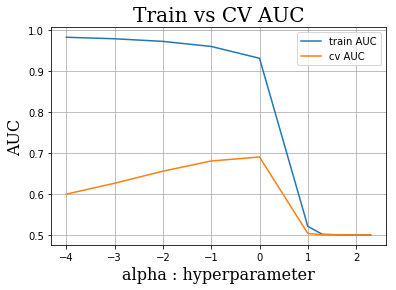

In [11]:
plt.plot(np.log10(params['alpha']), gs.cv_results_['mean_train_score'], label='train AUC')
plt.plot(np.log10(params['alpha']), gs.cv_results_['mean_test_score'], label='cv AUC')

plt.title('Train vs CV AUC', fontsize=20, fontfamily='serif')
plt.xlabel('alpha : hyperparameter', fontsize=16, fontfamily='serif')
plt.ylabel('AUC', fontsize=16, fontfamily='serif')
plt.grid()
plt.legend();

In [12]:
best_alpha = 1

clf = MultinomialNB(alpha = best_alpha, class_prior=[0.5, 0.5]).fit(X_tr, y_train)

y_pred_train = clf.predict_proba(X_tr)[:, 1]
y_pred_test = clf.predict_proba(X_te)[:, 1]

accuracy_train = metrics.roc_auc_score(y_train, y_pred_train)
accuracy_test = metrics.roc_auc_score(y_test, y_pred_test)

print('Train accuracy: ', accuracy_train)
print('Test accuracy: ', accuracy_test)

Train accuracy:  0.9207705891474798
Test accuracy:  0.7002529897111553


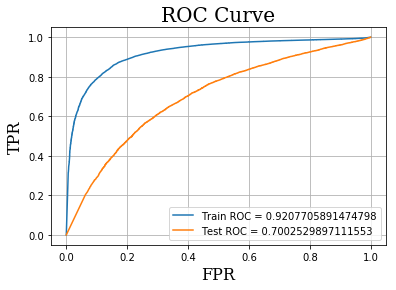

In [13]:
fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_pred_train)

fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, y_pred_test)

plt.plot(fpr_train, tpr_train, label='Train ROC = {}'.format(accuracy_train))
plt.plot(fpr_test, tpr_test, label='Test ROC = {}'.format(accuracy_test))

plt.title('ROC Curve', fontsize=20, fontfamily='serif')
plt.xlabel('FPR', fontsize=16, fontfamily='serif')
plt.ylabel('TPR', fontsize=16, fontfamily='serif')
plt.grid()
plt.legend()
plt.show();

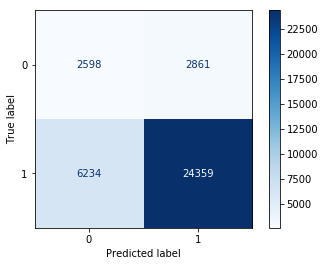

In [14]:
# https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels

cm = metrics.confusion_matrix(y_test, clf.predict(X_te))
# cmd = metrics.ConfusionMatrixDisplay(cm, display_labels=['0','1'])
metrics.plot_confusion_matrix(clf, X_te, y_test, cmap='Blues');

In [15]:
all_featur_names = np.array(all_featur_names)

print(10*'=', 'Top 20 positive features', 10*'=')
top_20_positive_features = all_featur_names[np.argsort(clf.feature_log_prob_[1])[::-1][:20]].tolist()
print(top_20_positive_features)

print('\n', 10*'=', 'Top 20 negative features', 10*'=')
top_20_negative_features = all_featur_names[np.argsort(clf.feature_log_prob_[0])[::-1][:20]].tolist()
print(top_20_negative_features)

========== Top 20 positive features ==========
['students', 'school', 'my', 'learning', 'classroom', 'the', 'not', 'they', 'my students', 'learn', 'help', 'price', 'many', 'nannan', 'we', 'reading', 'work', 'need', 'use', 'teacher_number_of_previously_posted_projects']

 ========== Top 20 negative features ==========
['students', 'school', 'learning', 'my', 'classroom', 'not', 'learn', 'they', 'help', 'the', 'my students', 'price', 'nannan', 'many', 'we', 'need', 'work', 'come', 'teacher_number_of_previously_posted_projects', 'reading']


# ============== TF-IDF vectorizer ==============

In [16]:
vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1,4), max_features=50000)

vectorizer.fit(X_train['essay'].values)

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_tfidf = vectorizer.transform(X_train['essay'].values)
X_test_essay_tfidf = vectorizer.transform(X_test['essay'].values)

all_featur_names = []
all_featur_names.extend(vectorizer.get_feature_names())

print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_test_essay_tfidf.shape, y_test.shape)

After vectorizations
(73196, 50000) (73196,)
(36052, 50000) (36052,)


In [17]:
import numpy as np
from scipy.sparse import hstack, csr_matrix  #https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html

cat_feat = ['school_state', 'teacher_prefix', 'project_grade_category', 'clean_categories', 'clean_subcategories']

X_train_cat_feat_ohe = csr_matrix((len(X_train), 0), dtype=np.int64)
X_test_cat_feat_ohe = csr_matrix((len(X_test), 0), dtype=np.int64)

for cat in cat_feat:
    vectorizer = CountVectorizer()
    vectorizer.fit(X_train[cat].values)
    X_train_cat_feat_ohe = hstack((X_train_cat_feat_ohe, vectorizer.transform(X_train[cat].values))).tocsr()
    X_test_cat_feat_ohe = hstack((X_test_cat_feat_ohe, vectorizer.transform(X_test[cat].values))).tocsr()
    
    all_featur_names.extend(vectorizer.get_feature_names())

print("="*10, 'After vectorizing all categorical features and horizontally stacking:', "="*10)
print(X_train_cat_feat_ohe.shape)
print(X_test_cat_feat_ohe.shape)

========== After vectorizing all categorical features and horizontally stacking: ==========
(73196, 99)
(36052, 99)


In [18]:
from sklearn.preprocessing import Normalizer

num_feat = ['teacher_number_of_previously_posted_projects', 'price']

X_train_num_feat_norm = np.empty((len(X_train), 0)) #https://stackoverflow.com/questions/18449136/initialize-empty-matrix-in-python
X_test_num_feat_norm = np.empty((len(X_test), 0))

for num in num_feat:
    normalizer = Normalizer()
    normalizer.fit(X_train[num].values.reshape(-1,1))
    X_train_num_feat_norm = np.hstack((X_train_num_feat_norm, normalizer.transform(X_train[num].values.reshape(-1,1))))
    X_test_num_feat_norm = np.hstack((X_test_num_feat_norm, normalizer.transform(X_test[num].values.reshape(-1,1))))
    
    all_featur_names.append(num)

print("="*10, 'After normalizing all numerical features and horizontally stacking:', "="*10)
print(X_train_num_feat_norm.shape)
print(X_test_num_feat_norm.shape)

========== After normalizing all numerical features and horizontally stacking: ==========
(73196, 2)
(36052, 2)


In [19]:
X_tr = hstack((X_train_essay_tfidf, X_train_cat_feat_ohe, X_train_num_feat_norm)).tocsr()
X_te = hstack((X_test_essay_tfidf, X_test_cat_feat_ohe, X_test_num_feat_norm)).tocsr()

print("="*10, "Final Data matrix", "="*10)
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)

========== Final Data matrix ==========
(73196, 50101) (73196,)
(36052, 50101) (36052,)


In [20]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
skf = StratifiedKFold(n_splits=10)
params = {'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10, 20, 50, 100, 200]}

gs = GridSearchCV(nb, cv=skf, param_grid=params, scoring='roc_auc', n_jobs=-1, return_train_score=True)
gs.fit(X_tr, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 20, 50, 100,
                                   200]},
             return_train_score=True, scoring='roc_auc')

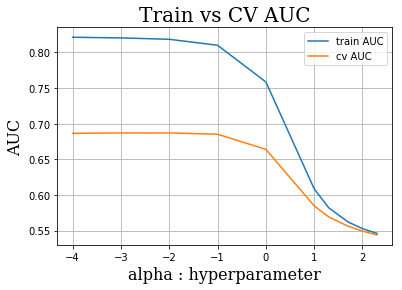

In [21]:
plt.plot(np.log10(params['alpha']), gs.cv_results_['mean_train_score'], label='train AUC')
plt.plot(np.log10(params['alpha']), gs.cv_results_['mean_test_score'], label='cv AUC')

plt.title('Train vs CV AUC', fontsize=20, fontfamily='serif')
plt.xlabel('alpha : hyperparameter', fontsize=16, fontfamily='serif')
plt.ylabel('AUC', fontsize=16, fontfamily='serif')
plt.grid()
plt.legend();

In [22]:
best_alpha = 0.1

clf = MultinomialNB(alpha = best_alpha).fit(X_tr, y_train)

y_pred_train = clf.predict_proba(X_tr)[:, 1]
y_pred_test = clf.predict_proba(X_te)[:, 1]

accuracy_train = metrics.roc_auc_score(y_train, y_pred_train)
accuracy_test = metrics.roc_auc_score(y_test, y_pred_test)

print('Train accuracy: ', accuracy_train)
print('Test accuracy: ', accuracy_test)

Train accuracy:  0.8006180698749147
Test accuracy:  0.6939468688853492


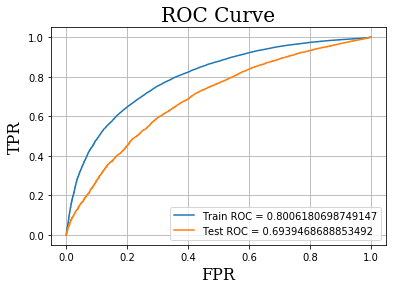

In [23]:
fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_pred_train)

fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, y_pred_test)

plt.plot(fpr_train, tpr_train, label='Train ROC = {}'.format(accuracy_train))
plt.plot(fpr_test, tpr_test, label='Test ROC = {}'.format(accuracy_test))

plt.title('ROC Curve', fontsize=20, fontfamily='serif')
plt.xlabel('FPR', fontsize=16, fontfamily='serif')
plt.ylabel('TPR', fontsize=16, fontfamily='serif')
plt.grid()
plt.legend()
plt.show();

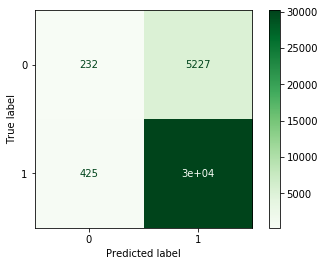

In [24]:
# https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels

cm = metrics.confusion_matrix(y_test, clf.predict(X_te))
# cmd = metrics.ConfusionMatrixDisplay(cm, display_labels=['0','1'])
metrics.plot_confusion_matrix(clf, X_te, y_test, cmap='Greens');

In [25]:
all_featur_names = np.array(all_featur_names)

print(10*'=', 'Top 20 positive features', 10*'=')
top_20_positive_features = all_featur_names[np.argsort(clf.feature_log_prob_[1])[::-1][:20]].tolist()
print(top_20_positive_features)

print('\n', 10*'=', 'Top 20 negative features', 10*'=')
top_20_negative_features = all_featur_names[np.argsort(clf.feature_log_prob_[0])[::-1][:20]].tolist()
print(top_20_negative_features)

========== Top 20 positive features ==========
['price', 'teacher_number_of_previously_posted_projects', 'mrs', 'literacy_language', 'grades_prek_2', 'math_science', 'ms', 'grades_3_5', 'literacy', 'mathematics', 'literature_writing', 'grades_6_8', 'ca', 'health_sports', 'specialneeds', 'specialneeds', 'appliedlearning', 'grades_9_12', 'appliedsciences', 'mr']

 ========== Top 20 negative features ==========
['price', 'teacher_number_of_previously_posted_projects', 'mrs', 'literacy_language', 'grades_prek_2', 'math_science', 'ms', 'grades_3_5', 'mathematics', 'literacy', 'literature_writing', 'grades_6_8', 'specialneeds', 'specialneeds', 'health_sports', 'ca', 'appliedlearning', 'appliedsciences', 'grades_9_12', 'mr']


# ============== Average W2V ===============

In [26]:
import pickle
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [37]:
# print(model['mallinson'])

In [36]:
# print(model.keys())

In [29]:
def avg_w2v(X):
    avg_w2v_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(X.values): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if word in glove_words:
                vector += model[word]
                cnt_words += 1
        if cnt_words != 0:
            vector /= cnt_words
        avg_w2v_vectors_train.append(vector)
    return np.array(avg_w2v_vectors_train)
    
avg_w2v_vectors_train = avg_w2v(X_train['essay'])
avg_w2v_vectors_test = avg_w2v(X_test['essay'])

print(len(avg_w2v_vectors_train))
print(len(avg_w2v_vectors_train[0]))
# print(avg_w2v_vectors_train[0])

100%|██████████████████████████████████████████████████████████████████████████| 36052/36052 [00:14<00:00, 2497.67it/s]


73196
300


In [30]:
all_featur_names = ['f'+str(i) for i in range(len(avg_w2v_vectors_train[0]))]
# print(all_featur_names)
avg_w2v_vectors_train = np.array(avg_w2v_vectors_train)

In [31]:
import numpy as np
from scipy.sparse import hstack, csr_matrix  #https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html

cat_feat = ['school_state', 'teacher_prefix', 'project_grade_category', 'clean_categories', 'clean_subcategories']

X_train_cat_feat_ohe = csr_matrix((len(X_train), 0), dtype=np.int64)
X_test_cat_feat_ohe = csr_matrix((len(X_test), 0), dtype=np.int64)

for cat in cat_feat:
    vectorizer = CountVectorizer()
    vectorizer.fit(X_train[cat].values)
    X_train_cat_feat_ohe = hstack((X_train_cat_feat_ohe, vectorizer.transform(X_train[cat].values))).tocsr()
    X_test_cat_feat_ohe = hstack((X_test_cat_feat_ohe, vectorizer.transform(X_test[cat].values))).tocsr()
    
    all_featur_names.extend(vectorizer.get_feature_names())

print("="*10, 'After vectorizing all categorical features and horizontally stacking:', "="*10)
print(X_train_cat_feat_ohe.shape)
print(X_test_cat_feat_ohe.shape)

========== After vectorizing all categorical features and horizontally stacking: ==========
(73196, 99)
(36052, 99)


In [32]:
from sklearn.preprocessing import Normalizer

num_feat = ['teacher_number_of_previously_posted_projects', 'price']

X_train_num_feat_norm = np.empty((len(X_train), 0)) #https://stackoverflow.com/questions/18449136/initialize-empty-matrix-in-python
X_test_num_feat_norm = np.empty((len(X_test), 0))

for num in num_feat:
    normalizer = Normalizer()
    normalizer.fit(X_train[num].values.reshape(-1,1))
    X_train_num_feat_norm = np.hstack((X_train_num_feat_norm, normalizer.transform(X_train[num].values.reshape(-1,1))))
    X_test_num_feat_norm = np.hstack((X_test_num_feat_norm, normalizer.transform(X_test[num].values.reshape(-1,1))))
    
    all_featur_names.append(num)

print("="*10, 'After normalizing all numerical features and horizontally stacking:', "="*10)
print(X_train_num_feat_norm.shape)
print(X_test_num_feat_norm.shape)

========== After normalizing all numerical features and horizontally stacking: ==========
(73196, 2)
(36052, 2)


In [33]:
X_tr = hstack((avg_w2v_vectors_train, X_train_cat_feat_ohe, X_train_num_feat_norm)).tocsr()
X_te = hstack((avg_w2v_vectors_test, X_test_cat_feat_ohe, X_test_num_feat_norm)).tocsr()

print("="*10, "Final Data matrix", "="*10)
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)

========== Final Data matrix ==========
(73196, 401) (73196,)
(36052, 401) (36052,)


In [34]:
X_tr[X_tr < 0]

matrix([[-0.06531343, -0.01673699, -3.20943849, ..., -0.10204413,
         -0.07827817, -0.03079163]])

In [35]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
skf = StratifiedKFold(n_splits=10)
params = {'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10, 20, 50, 100, 200]}

gs = GridSearchCV(nb, cv=skf, param_grid=params, scoring='roc_auc', n_jobs=-1, return_train_score=True)
gs.fit(X_tr, y_train)

ValueError: Negative values in data passed to MultinomialNB (input X)

In [ ]:
plt.plot(np.log10(params['alpha']), gs.cv_results_['mean_train_score'], label='train AUC')
plt.plot(np.log10(params['alpha']), gs.cv_results_['mean_test_score'], label='cv AUC')

plt.title('Train vs CV AUC', fontsize=20, fontfamily='serif')
plt.xlabel('alpha : hyperparameter', fontsize=16, fontfamily='serif')
plt.ylabel('AUC', fontsize=16, fontfamily='serif')
plt.grid()
plt.legend();

In [ ]:
best_alpha = 0.1

clf = MultinomialNB(alpha = best_alpha).fit(X_tr, y_train)

y_pred_train = clf.predict_proba(X_tr)[:, 1]
y_pred_test = clf.predict_proba(X_te)[:, 1]

accuracy_train = metrics.roc_auc_score(y_train, y_pred_train)
accuracy_test = metrics.roc_auc_score(y_test, y_pred_test)

print('Train accuracy: ', accuracy_train)
print('Test accuracy: ', accuracy_test)

In [ ]:
fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_pred_train)

fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, y_pred_test)

plt.plot(fpr_train, tpr_train, label='Train ROC = {}'.format(accuracy_train))
plt.plot(fpr_test, tpr_test, label='Test ROC = {}'.format(accuracy_test))

plt.title('ROC Curve', fontsize=20, fontfamily='serif')
plt.xlabel('FPR', fontsize=16, fontfamily='serif')
plt.ylabel('TPR', fontsize=16, fontfamily='serif')
plt.grid()
plt.legend()
plt.show();

<h1>3. Summary</h1>

<br> as mentioned in the step 5 of instructions